In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
from haversine import haversine, Unit
from scipy.stats import skew, kurtosis
sns.set() 
%matplotlib inline 

In [4]:
# Importing the provided dataset from the data folder.
df = pd.read_csv('nyc_taxi_trip_duration Dataset.csv')

In [5]:
print('The value of largest 5 trip duration values are as follows : \n {} '.format(df['trip_duration'].nlargest(5)))
print('The the number of rows with 1 as their trip duration values is {}'.format(len(df[df['trip_duration']==1 ])))

The value of largest 5 trip duration values are as follows : 
 21813     1939736
259437      86391
119185      86387
177225      86378
496391      86377
Name: trip_duration, dtype: int64 
The the number of rows with 1 as their trip duration values is 13


In [7]:
df=df[df.trip_duration!=df.trip_duration.max()]
df=df[df.trip_duration!=df.trip_duration.min()]

In [8]:
df['trip_duration_hour']=df['trip_duration']/3600

In [9]:
df.passenger_count.value_counts()

1    517403
2    105096
5     38926
3     29692
6     24107
4     14050
0        32
7         1
9         1
Name: passenger_count, dtype: int64

In [19]:
df=df[df.passenger_count<=6]
df=df[df.passenger_count!=0]

In [21]:
# Creating features based on month
df['pickup_by_month'] = df['pickup_datetime'].dt.month
df['dropoff_by_month'] = df['dropoff_datetime'].dt.month

In [22]:
# Creating features based on month
df['pickup_by_month'] = df['pickup_datetime'].dt.month
df['dropoff_by_month'] = df['dropoff_datetime'].dt.month

In [23]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

In [24]:
df['pickup_month'].value_counts()

3    128307
4    125627
5    124194
2    119354
6    117404
1    114388
Name: pickup_month, dtype: int64

In [25]:
df['dropoff_month'].value_counts()

3    128275
4    125626
5    124229
2    119351
6    117378
1    114362
7        53
Name: dropoff_month, dtype: int64

In [26]:
print(df[df.dropoff_month==7].pickup_datetime.dt.month.value_counts())
print(df[df.dropoff_month==7].pickup_datetime.dt.day.value_counts())

6    53
Name: pickup_datetime, dtype: int64
30    53
Name: pickup_datetime, dtype: int64


In [31]:
import haversine

In [68]:
#a function is created to calculate the distance from latitudes and longitudes
from math import radians, cos, sin, sqrt
def haversine(df):
    lat1, lon1, lat2, lon2=df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude
    R=3959.87433
    dLat=radians(lat2-lat1)
    dLon=radians(lon2-lon1)
    lat1=radians(lat1)
    lat2=radians(lat2)
    a=sin(dLat/2)**2+cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c=2*asin(sqrt(a))
    return R*c

In [69]:
df['distance']=df.apply(lambda x: haversine(x), axis=1)

<AxesSubplot:xlabel='distance', ylabel='trip_duration'>

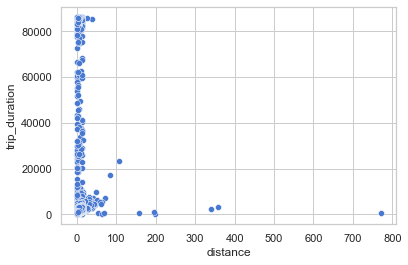

In [71]:
sns.scatterplot(x='distance', y='trip_duration', data=df)

In [72]:
print('The no of rows with distance =0 are {}'.format(len(df[df.distance==0])))

The no of rows with distance =0 are 2889


In [73]:
mean_dist=df['distance'].mean()
df.loc[df['distance']==0,'distance']=mean_dist

C:\Users\sd800\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='speed'>

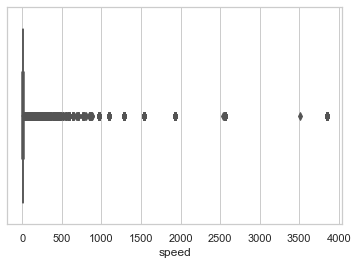

In [74]:
df['speed']=df['distance']/df['trip_duration_hour']
sns.boxplot(df['speed'])

<AxesSubplot:xlabel='distance', ylabel='trip_duration_hour'>

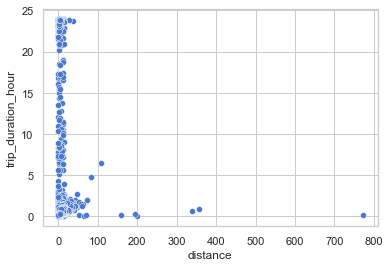

In [75]:
#distribution of the distance variable against the trip duration in hour feature
sns.scatterplot(x='distance',y='trip_duration_hour',data=df)

<AxesSubplot:xlabel='log_distance', ylabel='log_trip_duration'>

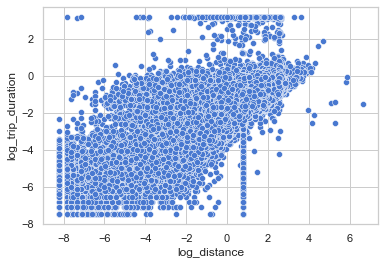

In [76]:
# log transform these columns and have a look at the distribution again
df['log_distance']=np.log(df.distance)
df['log_trip_duration']=np.log(df.trip_duration_hour)
sns.scatterplot(x='log_distance',y='log_trip_duration',data=df)

In [77]:
df=df[df.log_trip_duration<2]

In [78]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'trip_duration_hour', 'pickup_day', 'dropoff_day',
       'pickup_month', 'dropoff_month', 'pickup_by_month', 'dropoff_by_month',
       'distance', 'speed', 'log_distance', 'log_trip_duration'],
      dtype='object')

### Now, we won’t use all of them to build our model as this would make the model very complex. We create a new data frame data2 to select only the features which had some effect on the target variable trip_duration.We dropped certain features as they were transformed to other features. We dropped the nominal features as well.

In [86]:
data2=df.reindex(columns=['passenger_count', 'store_and_fwd_flag', 'trip_duration', 'pickup_day','dropoff_day', 'pickup_month', 'dropoff_month', 'pickup_timezone', 'dropoff_timezone'])

In [87]:
data2=pd.get_dummies(data2,columns=['store_and_fwd_flag','pickup_day','dropoff_day','pickup_month','dropoff_month','pickup_timezone', 'dropoff_timezone'])

In [88]:
base_line_col=['distance']
predictor_cols=['passenger_count','distance','store_and_fwd_flag_N','store_and_fwd_flag_Y',
'pickup_day_Friday','pickup_day_Monday','pickup_day_Saturday','pickup_day_Sunday',
'pickup_day_Thursday','pickup_day_Tuesday','pickup_day_Wednesday','dropoff_day_Friday',
'dropoff_day_Monday','dropoff_day_Saturday','dropoff_day_Sunday','dropoff_day_Thursday',
'dropoff_month_1','dropoff_month_5','dropoff_month_6','pickup_timezone_late night',
'pickup_timezone_midday','pickup_timezone_morning','dropoff_timezone_evening',
'dropoff_timezone_late night','dropoff_timezone_midday','dropoff_timezone_morning']
target_col=['trip_duration']

In [89]:
from sklearn import  metrics
from sklearn.model_selection import cross_val_score
def modelfit(estimator,data_train,data_test,predictors,target):
    #print(data_train.head())
    #fitting model
    estimator.fit(data_train[predictors],data_train.loc[:,target])
    #train data prediction
    train_pred=estimator.predict(data_train[predictors])
    #cross_validation score
    cv_score=cross_val_score(estimator,data_train[predictors],data_train.loc[:,target],cv=20,scoring='neg_mean_squared_error')
    
    cv_score=np.sqrt(np.abs(cv_score))
    #Print model report:
    print ("\nModel Report")
    print ("RMSE on Train Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_train.loc[:,target].values, train_pred)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    test_pred=estimator.predict(data_test[predictors])
    print ("RMSE on Test Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_test.loc[:,target].values, test_pred)))
    
    
    
    return test_pred

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
validation_size = 0.20
seed = 7
X_train, X_test = train_test_split(data2,test_size=validation_size, random_state=seed)

In [91]:
mean_pred=np.repeat(X_train[target_col].mean(),len(X_test[target_col]))
from sklearn.metrics import mean_squared_error as mae
sqrt(mae(X_test[target_col],mean_pred))

664.1583834380903

In [120]:
alg1 = LinearRegression(normalize=True)
print('The baseline model')
y_pred=modelfit(alg1, X_train, X_test,base_line_col,target_col)
coef1 = alg1.coef_
print('The coeffient is {}'.format(coef1))

The baseline model


KeyError: "None of [Index(['distance'], dtype='object')] are in the [columns]"

In [121]:
alg2 = LinearRegression(normalize=True)
y_pred=modelfit(alg2, X_train, X_test, predictor_cols,target_col)
coef1 = pd.Series(alg2.coef_[0], predictor_cols).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

KeyError: "['dropoff_timezone_morning', 'distance', 'dropoff_timezone_late night', 'pickup_timezone_morning', 'pickup_timezone_midday', 'pickup_timezone_late night', 'dropoff_timezone_evening', 'dropoff_timezone_midday'] not in index"

In [122]:
residuals=y_pred-X_test[target_col]Heteroskedasticity
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,145510)
k = [0 for i in range(0,145510)]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

SyntaxError: invalid syntax (<ipython-input-122-37f86e5a5804>, line 1)

In [125]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_by_month,dropoff_by_month,distance,speed,log_distance,log_trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,Monday,Monday,2,2,2,2,0.745280,6.707517,-0.293996,-2.197225
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,Friday,Friday,3,3,3,3,2.566436,8.399243,0.942518,-1.185624
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,Sunday,Sunday,2,2,2,2,4.506682,9.922969,1.505561,-0.789291
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,Tuesday,Tuesday,1,1,1,1,1.467532,4.630251,0.383582,-1.149029
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,Wednesday,Wednesday,2,2,2,2,2.690386,11.421451,0.989685,-1.445808
